In [10]:
import requests
import pandas as pd
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

In [11]:
df = pd.read_csv('pv_test.csv')

In [12]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%d %H:%M:%S')

In [13]:
df

,Datetime,electricity
0,2001-09-09 04:00:00,0.000
1,2001-09-09 05:00:00,0.000
2,2001-09-09 06:00:00,0.054
3,2001-09-09 07:00:00,0.264
4,2001-09-09 08:00:00,0.448
...,...,...
52577,2006-12-31 19:00:00,0.000
52578,2006-12-31 20:00:00,0.000
52579,2006-12-31 21:00:00,0.000
52580,2006-12-31 22:00:00,0.000


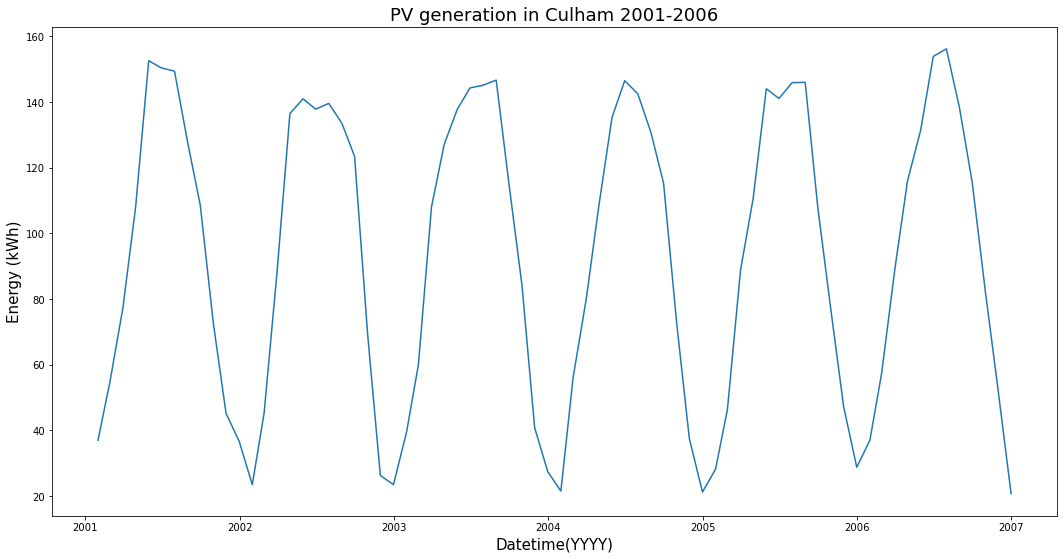

In [14]:
daydf = df.groupby(pd.Grouper(key='Datetime', freq='1M')).sum().reset_index()
plt.figure(figsize=(18,9))
plt.plot(daydf['Datetime'],daydf['electricity'])
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Datetime(YYYY)',fontsize=15)
plt.ylabel('Energy (kWh)',fontsize=15)
plt.title('PV generation in Culham 2001-2006',fontsize=18)
plt.show()

In [15]:
daydf

,Datetime,electricity
0,2001-01-31,37.005
1,2001-02-28,54.569
2,2001-03-31,77.325
3,2001-04-30,107.960
4,2001-05-31,152.560
...,...,...
67,2006-08-31,138.191
68,2006-09-30,115.593
69,2006-10-31,82.448
70,2006-11-30,52.592


In [16]:
daydf = daydf[daydf['Datetime'] <= '2006-01-01']

In [17]:
daydf_train = daydf[:-12]
daydf_test = daydf[-12:]

In [18]:
daydf_train

,Datetime,electricity
0,2001-01-31,37.005
1,2001-02-28,54.569
2,2001-03-31,77.325
3,2001-04-30,107.960
4,2001-05-31,152.560
5,2001-06-30,150.375
6,2001-07-31,149.383
7,2001-08-31,127.779
8,2001-09-30,108.556
9,2001-10-31,72.521


In [114]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size)) # (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1,-1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [115]:
train_window = 36
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [116]:
train_data = np.array(daydf_train['electricity'])

In [117]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

train_data_normalized = torch.tensor(train_data_normalized)
train_data_normalized = train_data_normalized.to(torch.float32)

In [118]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [119]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [120]:
epochs = 150

for i in tqdm(range(epochs)):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels[0])
        single_loss.backward()
        optimizer.step()

    print(f'epoch: {i} loss: {single_loss.item():10.8f}')

print(f'epoch: {i} loss: {single_loss.item():10.10f}')

  1%|█                                                                                 | 2/150 [00:00<00:10, 13.46it/s]

epoch: 0 loss: 0.93760693
epoch: 1 loss: 0.93721926
epoch: 2 loss: 0.91422313


  4%|███▎                                                                              | 6/150 [00:00<00:09, 14.45it/s]

epoch: 3 loss: 0.85676336
epoch: 4 loss: 0.69593680
epoch: 5 loss: 0.01724460
epoch: 6 loss: 0.12517752


  7%|█████▍                                                                           | 10/150 [00:00<00:09, 14.23it/s]

epoch: 7 loss: 0.00327489
epoch: 8 loss: 0.02747584
epoch: 9 loss: 0.13214369


  8%|██████▍                                                                          | 12/150 [00:00<00:09, 14.33it/s]

epoch: 10 loss: 0.00319538
epoch: 11 loss: 0.00027009
epoch: 12 loss: 0.00000091


 11%|████████▋                                                                        | 16/150 [00:01<00:09, 14.23it/s]

epoch: 13 loss: 0.00221454
epoch: 14 loss: 0.00831811
epoch: 15 loss: 0.00230944


 13%|██████████▊                                                                      | 20/150 [00:01<00:08, 14.63it/s]

epoch: 16 loss: 0.00478411
epoch: 17 loss: 0.00073964
epoch: 18 loss: 0.00391606
epoch: 19 loss: 0.00086435


 16%|████████████▉                                                                    | 24/150 [00:01<00:08, 14.94it/s]

epoch: 20 loss: 0.00338237
epoch: 21 loss: 0.00162489
epoch: 22 loss: 0.00250028
epoch: 23 loss: 0.00239073


 17%|██████████████                                                                   | 26/150 [00:01<00:08, 13.89it/s]

epoch: 24 loss: 0.00196891
epoch: 25 loss: 0.00267519
epoch: 26 loss: 0.00205057


 20%|████████████████▏                                                                | 30/150 [00:02<00:08, 14.21it/s]

epoch: 27 loss: 0.00239711
epoch: 28 loss: 0.00241594
epoch: 29 loss: 0.00216470
epoch: 30 loss: 0.00247759


 23%|██████████████████▎                                                              | 34/150 [00:02<00:07, 14.81it/s]

epoch: 31 loss: 0.00234165
epoch: 32 loss: 0.00226353
epoch: 33 loss: 0.00248270


 25%|████████████████████▌                                                            | 38/150 [00:02<00:07, 14.87it/s]

epoch: 34 loss: 0.00237214
epoch: 35 loss: 0.00226524
epoch: 36 loss: 0.00254833
epoch: 37 loss: 0.00240456


 27%|█████████████████████▌                                                           | 40/150 [00:02<00:08, 13.45it/s]

epoch: 38 loss: 0.00220198
epoch: 39 loss: 0.00268486
epoch: 40 loss: 0.00245697


 29%|███████████████████████▊                                                         | 44/150 [00:03<00:07, 14.28it/s]

epoch: 41 loss: 0.00199935
epoch: 42 loss: 0.00296154
epoch: 43 loss: 0.00263310
epoch: 44 loss: 0.00142698


 32%|█████████████████████████▉                                                       | 48/150 [00:03<00:07, 14.19it/s]

epoch: 45 loss: 0.00352326
epoch: 46 loss: 0.00343360
epoch: 47 loss: 0.00020034


 33%|███████████████████████████                                                      | 50/150 [00:03<00:06, 14.35it/s]

epoch: 48 loss: 0.00405869
epoch: 49 loss: 0.00782506
epoch: 50 loss: 0.00817613


 36%|█████████████████████████████▏                                                   | 54/150 [00:03<00:06, 14.07it/s]

epoch: 51 loss: 0.00032032
epoch: 52 loss: 0.00950280
epoch: 53 loss: 0.15644567
epoch: 54 loss: 0.00006354


 39%|███████████████████████████████▎                                                 | 58/150 [00:04<00:06, 14.46it/s]

epoch: 55 loss: 0.00263780
epoch: 56 loss: 0.00309110
epoch: 57 loss: 0.00000469


 40%|████████████████████████████████▍                                                | 60/150 [00:04<00:06, 14.47it/s]

epoch: 58 loss: 0.00990916
epoch: 59 loss: 0.00022746
epoch: 60 loss: 0.00638544


 43%|██████████████████████████████████▌                                              | 64/150 [00:04<00:06, 13.70it/s]

epoch: 61 loss: 0.00159029
epoch: 62 loss: 0.00257393
epoch: 63 loss: 0.00403810


 45%|████████████████████████████████████▋                                            | 68/150 [00:04<00:05, 14.18it/s]

epoch: 64 loss: 0.00135293
epoch: 65 loss: 0.00426370
epoch: 66 loss: 0.00210180
epoch: 67 loss: 0.00273450


 48%|██████████████████████████████████████▉                                          | 72/150 [00:05<00:05, 14.29it/s]

epoch: 68 loss: 0.00347262
epoch: 69 loss: 0.00193130
epoch: 70 loss: 0.00355840
epoch: 71 loss: 0.00254639


 49%|███████████████████████████████████████▉                                         | 74/150 [00:05<00:05, 14.43it/s]

epoch: 72 loss: 0.00246865
epoch: 73 loss: 0.00349632
epoch: 74 loss: 0.00214453


 52%|██████████████████████████████████████████                                       | 78/150 [00:05<00:05, 13.39it/s]

epoch: 75 loss: 0.00305003
epoch: 76 loss: 0.00310418
epoch: 77 loss: 0.00206557


 53%|███████████████████████████████████████████▏                                     | 80/150 [00:05<00:05, 13.51it/s]

epoch: 78 loss: 0.00351326
epoch: 79 loss: 0.00262739
epoch: 80 loss: 0.00214951


 56%|█████████████████████████████████████████████▎                                   | 84/150 [00:05<00:04, 13.52it/s]

epoch: 81 loss: 0.00395349
epoch: 82 loss: 0.00200304
epoch: 83 loss: 0.00245083


 59%|███████████████████████████████████████████████▌                                 | 88/150 [00:06<00:04, 14.19it/s]

epoch: 84 loss: 0.00444932
epoch: 85 loss: 0.00108810
epoch: 86 loss: 0.00332562
epoch: 87 loss: 0.00490108


 61%|█████████████████████████████████████████████████▋                               | 92/150 [00:06<00:03, 14.83it/s]

epoch: 88 loss: 0.00006819
epoch: 89 loss: 0.00569226
epoch: 90 loss: 0.00459080
epoch: 91 loss: 0.00218116


 64%|███████████████████████████████████████████████████▊                             | 96/150 [00:06<00:03, 14.91it/s]

epoch: 92 loss: 0.00970087
epoch: 93 loss: 0.00201655
epoch: 94 loss: 0.01329692
epoch: 95 loss: 0.01397509


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [00:07<00:03, 14.69it/s]

epoch: 96 loss: 0.00084178
epoch: 97 loss: 0.00048316
epoch: 98 loss: 0.01348936
epoch: 99 loss: 0.01696442


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [00:07<00:03, 14.87it/s]

epoch: 100 loss: 0.00930110
epoch: 101 loss: 0.00104924
epoch: 102 loss: 0.00089295
epoch: 103 loss: 0.00857791


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [00:07<00:02, 14.91it/s]

epoch: 104 loss: 0.00003559
epoch: 105 loss: 0.00766175
epoch: 106 loss: 0.00117021


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [00:07<00:02, 14.18it/s]

epoch: 107 loss: 0.00202956
epoch: 108 loss: 0.00606480
epoch: 109 loss: 0.00013512


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [00:07<00:02, 14.24it/s]

epoch: 110 loss: 0.00651484
epoch: 111 loss: 0.00148990
epoch: 112 loss: 0.00179642
epoch: 113 loss: 0.00632040


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [00:08<00:02, 13.34it/s]

epoch: 114 loss: 0.00009133
epoch: 115 loss: 0.00606810
epoch: 116 loss: 0.00226430


 80%|████████████████████████████████████████████████████████████████                | 120/150 [00:08<00:02, 14.31it/s]

epoch: 117 loss: 0.00057081
epoch: 118 loss: 0.00851131
epoch: 119 loss: 0.00001137
epoch: 120 loss: 0.00482819


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [00:08<00:01, 14.38it/s]

epoch: 121 loss: 0.00504239
epoch: 122 loss: 0.00078865
epoch: 123 loss: 0.01124557
epoch: 124 loss: 0.00000989


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [00:08<00:01, 14.43it/s]

epoch: 125 loss: 0.00129517
epoch: 126 loss: 0.01112582
epoch: 127 loss: 0.01002367


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [00:09<00:01, 14.90it/s]

epoch: 128 loss: 0.00837656
epoch: 129 loss: 0.00127868
epoch: 130 loss: 0.00001732
epoch: 131 loss: 0.01209041


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [00:09<00:00, 14.84it/s]

epoch: 132 loss: 0.00392776
epoch: 133 loss: 0.00744580
epoch: 134 loss: 0.00168302
epoch: 135 loss: 0.00063757


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [00:09<00:00, 14.35it/s]

epoch: 136 loss: 0.00867047
epoch: 137 loss: 0.00023100
epoch: 138 loss: 0.00700249


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [00:09<00:00, 14.05it/s]

epoch: 139 loss: 0.00128655
epoch: 140 loss: 0.00146349
epoch: 141 loss: 0.00690418
epoch: 142 loss: 0.00000685


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [00:10<00:00, 13.12it/s]

epoch: 143 loss: 0.00671318
epoch: 144 loss: 0.00118174
epoch: 145 loss: 0.00141802


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [00:10<00:00, 13.18it/s]

epoch: 146 loss: 0.00714153
epoch: 147 loss: 0.00012216
epoch: 148 loss: 0.00680233


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:10<00:00, 14.22it/s]

epoch: 149 loss: 0.00134803
epoch: 149 loss: 0.0013480285


In [121]:
test_inputs = train_data_normalized[-train_window:].view(-1).tolist()

In [122]:
a = train_data_normalized[-train_window:].view(-1)

In [123]:
model.eval()
future_pred_num = 12
for i in range(future_pred_num):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        test_inputs.append(model(seq).item())


In [124]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(1, -1))[0]

In [125]:
ground_truth = np.array(daydf_test['electricity'])

In [126]:
ground_truth

array([ 28.212,  46.373,  88.772, 110.76 , 144.028, 141.065, 145.895,
       145.969, 107.639,  76.461,  47.174,  28.768])

In [127]:
arma = np.array([22.18771581,  47.08758836,  77.17346425, 115.32193054,
        144.31484604, 162.26255815, 158.67138453, 140.03669008,
        106.53203381,  71.67440159,  40.71763548,  25.66416586])

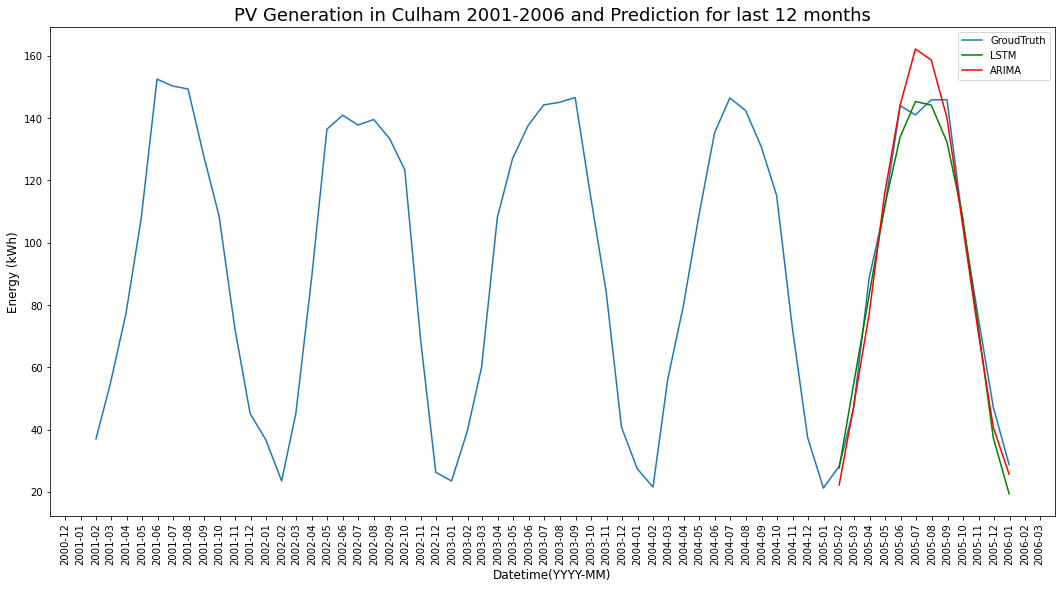

In [131]:
plt.figure(figsize=(18,9))
plt.plot(daydf['Datetime'],daydf['electricity'],label = 'GroudTruth')
plt.plot(daydf_test['Datetime'],actual_predictions,c='g',label = 'LSTM')
plt.plot(daydf_test['Datetime'],arma,c='r',label = 'ARIMA')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=90)
plt.xlabel('Datetime(YYYY-MM)',fontsize=12)
plt.ylabel('Energy (kWh)',fontsize=12)
plt.title('PV Generation in Culham 2001-2006 and Prediction for last 12 months',fontsize=18)
plt.legend(loc='best')
plt.show()